# Deep CV Using Convolutional Neural Networks 

In [11]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. CNNs can be very slow without a GPU.


In [12]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")


def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")


## A Convolution

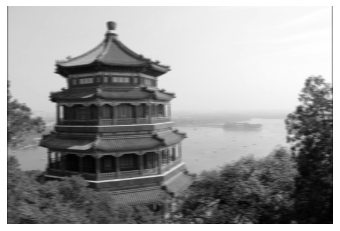

In [13]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# This is the part of the low-level Deep Learning API of Tensorflow
# The zero padding is used with a stride of 1
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray")  # plot 1st image's 2nd feature map
plt.axis("off")  # Not shown in the book
plt.show()


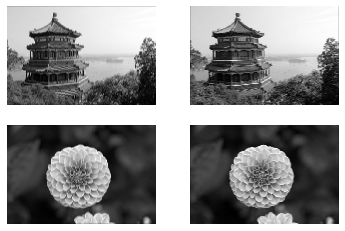

In [14]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [15]:
def crop(images):
    return images[150:220, 130:250]


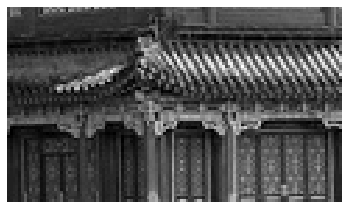

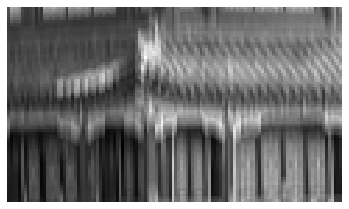

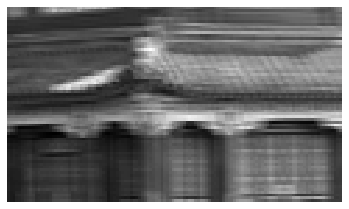

In [16]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()


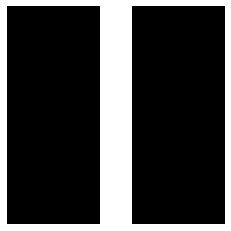

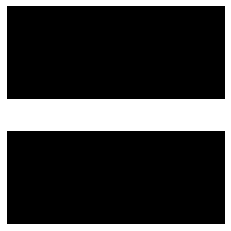

In [17]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()


## Convolutional Layer

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(
    filters=2,
    kernel_size=7,
    strides=1,
    padding="SAME",
    activation="relu",
    input_shape=outputs.shape,
)


In [21]:
conv_outputs = conv(images)
print(conv_outputs.shape)

# batch size == 2, for 2 images
# output size is the same as the input (427 X 640)
# the convolutional layer has 2 filters, so each input image generates 2 output feature maps
assert conv_outputs.shape == (2, 427, 640, 2)

(2, 427, 640, 2)


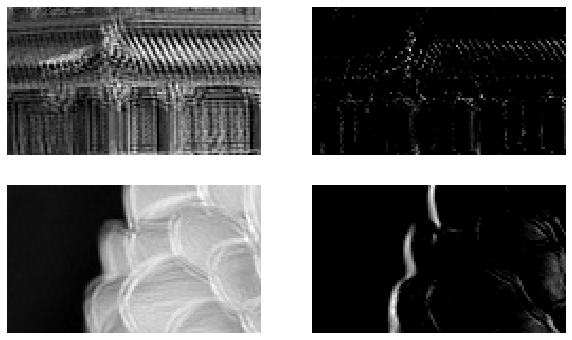

In [22]:
plt.figure(figsize=(10, 6))

for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))

plt.show()


Although the filters are randomly initialized. The second happens to be act like an edge detector.
Random initialized filters often act like this. 

In [23]:
# Use the manually defined filters with zero biases.
conv.set_weights([filters, np.zeros(2)])

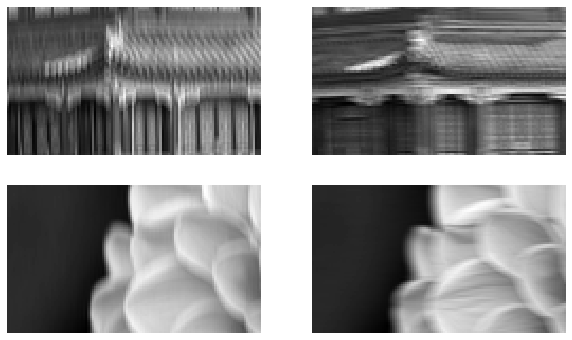

In [25]:
conv_outputs = conv(images)

plt.figure(figsize=(10, 6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()


## Pooling Layer

In [26]:
max_pool = keras.layers.MaxPool2D(pool_size=2)
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)


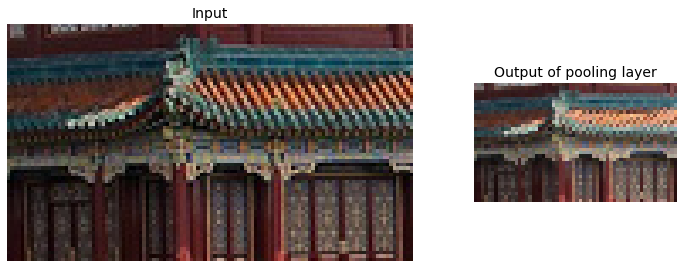

In [28]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output of pooling layer", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()


## Tackling Fashion MNIST with a CNN

In [29]:
(X_train_full, y_train_full), (
    X_test,
    y_test,
) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [31]:
from functools import partial

DefaultConv2D = partial(
    keras.layers.Conv2D, kernel_size=3, activation="relu", padding="SAME"
)

model = keras.models.Sequential(
    [
        DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
        keras.layers.MaxPooling2D(pool_size=2),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        keras.layers.MaxPooling2D(pool_size=2),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=64, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=10, activation="softmax"),
    ]
)


In [32]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]
)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
print(score)


Epoch 1/10
1719/1719 [==============================] - 343s 199ms/step - loss: 0.7330 - accuracy: 0.7421 - val_loss: 0.3819 - val_accuracy: 0.8638
Epoch 2/10
1719/1719 [==============================] - 354s 206ms/step - loss: 0.4336 - accuracy: 0.8537 - val_loss: 0.3153 - val_accuracy: 0.8864
Epoch 3/10
1719/1719 [==============================] - 361s 210ms/step - loss: 0.3743 - accuracy: 0.8741 - val_loss: 0.3302 - val_accuracy: 0.8824
Epoch 4/10
1719/1719 [==============================] - 347s 202ms/step - loss: 0.3458 - accuracy: 0.8845 - val_loss: 0.2887 - val_accuracy: 0.8950
Epoch 5/10
1719/1719 [==============================] - 362s 211ms/step - loss: 0.3177 - accuracy: 0.8934 - val_loss: 0.2920 - val_accuracy: 0.8970
Epoch 6/10
1719/1719 [==============================] - 361s 210ms/step - loss: 0.3010 - accuracy: 0.8997 - val_loss: 0.2803 - val_accuracy: 0.9008
Epoch 7/10
1719/1719 [==============================] - 374s 217ms/step - loss: 0.2807 - accuracy: 0.9048 - val_

## Using a Pre-trained Model

In [33]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 15s 0us/step


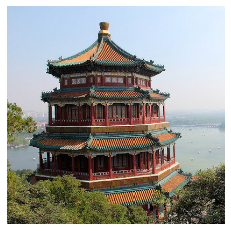

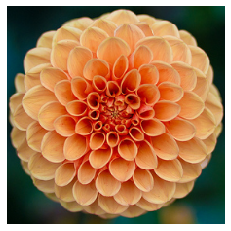

In [37]:
images_resized = tf.image.resize(images, [224, 224])
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)


china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(
    images, [china_box, flower_box], [0, 1], [224, 224]
)

plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()


In [38]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [39]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image: #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("    {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))


49152/35363 [=========================================] - 0s 1us/step
Image: #0
    n03877845 - palace       43.39%
    n02825657 - bell_cote    43.08%
    n03781244 - monastery    11.69%
Image: #1
    n04522168 - vase         53.97%
    n07930864 - cup          9.52%
    n11939491 - daisy        4.96%


## Pre-trained Models for Transfer Learning

There's some difficulty for me to install tensorflow-datasets package using pip...

## Mean Average Precision (mAP)

In [43]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))


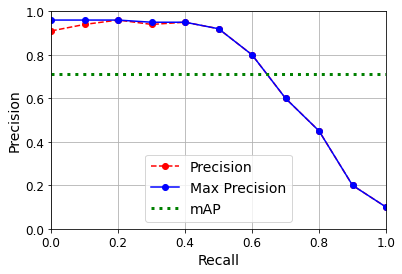

In [44]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()
